(sec-dask-ml-distributed-training)=
# Distributed Machine Learning

If the volume of training data is large, Dask-ML provides distributed machine learning capabilities that allow for training on big data across a cluster. Currently, Dask offers two types of distributed machine learning APIs:

* scikit-learn style
* XGBoost and LightGBM decision tree style

## scikit-learn API

Leveraging the distributed computing capabilities of Dask Array, Dask DataFrame, and Dask Delayed, Dask-ML has implemented distributed versions of machine learning algorithms, similar to scikit-learn. For example, in `dask_ml.linear_model`, there are linear regression [`LinearRegression`](https://ml.dask.org/modules/generated/dask_ml.linear_model.LinearRegression.html) and logistic regression [`LogisticRegression`](https://ml.dask.org/modules/generated/dask_ml.linear_model.LogisticRegression.html), and in `dask_ml.cluster`, there is [`KMeans`](https://ml.dask.org/modules/generated/dask_ml.cluster.KMeans.html). Dask-ML strives to keep the usage of these machine learning algorithms consistent with scikit-learn.

On a Dask cluster consisting of 2 computing nodes, use the linear models from `dask_ml.linear_model`. Each computing node in this cluster has 90GiB of memory, and we randomly generate a dataset of 37GiB, which is then split into a training set and a testing set.

In [1]:
%config InlineBackend.figure_format = 'svg'
import time

import seaborn as sns
import pandas as pd

from dask.distributed import Client, LocalCluster

In [ ]:
import dask_ml.datasets
import sklearn.linear_model
import dask_ml.linear_model
from dask_ml.model_selection import train_test_split

In [3]:
client = Client("10.0.0.3:8786")
client

<Client: 'tcp://10.0.0.3:8786' processes=2 threads=128, memory=180.00 GiB>

In [9]:
X, y = dask_ml.datasets.make_classification(n_samples=10_000_000, 
        n_features=500, 
        random_state=42,
        chunks=10_000_000 // 100
)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X

/fs/fast/u20200002/envs/dispy/lib/python3.11/site-packages/dask/base.py:1462: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(


dask.array<normal, shape=(10000000, 500), dtype=float64, chunksize=(100000, 500), chunktype=numpy.ndarray>

Call the scikit-learn sytle `fit()` method:

In [10]:
lr = dask_ml.linear_model.LogisticRegression(solver="lbfgs").fit(X_train, y_train)

/fs/fast/u20200002/envs/dispy/lib/python3.11/site-packages/dask/config.py:789: FutureWarning: Dask configuration key 'fuse_ave_width' has been deprecated; please use 'optimization.fuse.ave-width' instead
  warnings.warn(


The trained model can be used for prediction (`predict()`), as well as for calculating accuracy (`score()`).

In [12]:
y_predicted = lr.predict(X_test)
y_predicted[:5].compute()

array([ True, False,  True,  True,  True])

In [14]:
lr.score(X_test, y_test).compute()

0.668674

If the same size of data is used to train a model on a single machine with scikit-learn, it would result in an error due to insufficient memory.

Although the distributed training API of Dask-ML is extremely similar to scikit-learn, the fact that scikit-learn can only use one single core while Dask-ML can utilize multiple cores or even a cluster does not mean that Dask-ML should be chosen in all scenarios, as it is not always the best option in terms of performance or cost-effectiveness. This is similar to the relationship between Dask DataFrame and pandas; if the dataset can fit into the memory of a single machine, the performance and compatibility of native pandas, NumPy, and scikit-learn are always optimal.

The following code performs a performance analysis on training data of different scales. In scenarios where the data volume is small and running on a single machine with multiple cores, the performance of Dask-ML is not faster than scikit-learn. There are many reasons for this, including:

* Many machine learning algorithms are iterative. In scikit-learn, iterative algorithms are implemented using Python's native `for` loops; Dask-ML has adopted this approach of `for` loops. But for Dask's Task Graph, `for` loops can make the Task Graph quite bloated, and the execution efficiency is not very high.
* The distributed implementation requires distributing and collecting data across different processes, which adds a lot of extra data synchronization and communication overhead compared to a single machine and single process.

You can also test the performance based on the memory you have available.

In [4]:
client = Client(LocalCluster())
client

<Client: 'tcp://127.0.0.1:38477' processes=8 threads=64, memory=90.00 GiB>

/fs/fast/u20200002/envs/dispy/lib/python3.11/site-packages/dask/base.py:1462: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
/fs/fast/u20200002/envs/dispy/lib/python3.11/site-packages/dask/config.py:789: FutureWarning: Dask configuration key 'fuse_ave_width' has been deprecated; please use 'optimization.fuse.ave-width' instead
  warnings.warn(
/fs/fast/u20200002/envs/dispy/lib/python3.11/site-packages/dask/base.py:1462: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
/fs/fast/u20200002/envs/dispy/lib/python3.11/site-packages/dask/config.py:789: FutureWarning: Dask configuration key 'fuse_ave_width' has been deprecated; please use 'optimization.fuse.ave-width' instead
  warnings.warn(
/fs/fast/u20200002/envs/dispy/lib/python3.11/site-packages/dask/base.py:1462: UserWarning: Running on a single-machine schedul

<Axes: xlabel='# of samples', ylabel='time'>

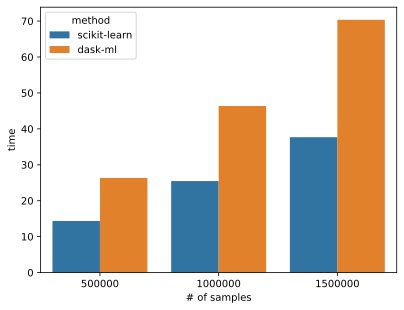

In [6]:
num_sample = [500_000, 1_000_000, 1_500_000]
num_feature = 1_000
timings = []

for n in num_sample:
    X, y = dask_ml.datasets.make_classification(n_samples=n, 
        n_features=num_feature, 
        random_state=42,
        chunks=n // 10
    )
    t1 = time.time()
    sklearn.linear_model.LogisticRegression(solver="lbfgs").fit(X, y)
    timings.append(('scikit-learn', n, time.time() - t1))
    t1 = time.time()
    dask_ml.linear_model.LogisticRegression(solver="lbfgs").fit(X, y)
    timings.append(('dask-ml', n, time.time() - t1))

df = pd.DataFrame(timings, columns=['method', '# of samples', 'time'])
sns.barplot(data=df, x='# of samples', y='time', hue='method')

In the context of logistic regression, Dask-ML does not offer significant advantages over scikit-learn when running on a single machine with multiple cores. Moreover, many traditional machine learning algorithms do not have high demands for large training data, and their performance does not increase significantly with the addition of more training data. The relationship between the volume of training data and model performance can be visualized through learning curves; for algorithms like Naive Bayes, performance improvements with increased training data are quite limited. If certain machine learning algorithms cannot be trained in a distributed manner or if the cost of distributed training is high, it might be worth considering sampling the training data to a size that fits into the memory of a single machine and using a single-machine framework like scikit-learn.

In summary, if you have training data that exceeds the memory capacity of a single machine, you should consider various factors.

## XGBoost and LightGBM

XGBoost and LightGBM are two implementations of decision tree models that are inherently friendly to distributed training and have been integrated with Dask. Below, we use an example to illustrate how to use Dask and XGBoost for distributed training, and LightGBM is similar.

In XGBoost, training a model can be done using either the `train()` method or the scikit-learn-style `fit()` method. Both approaches support Dask distributed training.

The code below compares the performance of single-machine XGBoost and Dask distributed training. When using Dask, users need to change [`xgboost.DMatrix`](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.DMatrix) to [`xgboost.dask.DaskDMatrix`](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.dask.DaskDMatrix), where `xgboost.dask.DaskDMatrix` can convert distributed Dask Arrays or Dask DataFrames into the data format required by XGBoost. Users also need to replace [`xgboost.train()`](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.train) with [`xgboost.dask.train()`](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.dask.train) and pass in the Dask cluster client `client`.

/fs/fast/u20200002/envs/dispy/lib/python3.11/site-packages/dask/base.py:1462: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
[22:13:43] task [xgboost.dask-0]:tcp://127.0.0.1:44219 got new rank 0
[22:13:43] task [xgboost.dask-1]:tcp://127.0.0.1:41549 got new rank 1
[22:13:43] task [xgboost.dask-2]:tcp://127.0.0.1:42877 got new rank 2
[22:13:43] task [xgboost.dask-3]:tcp://127.0.0.1:34321 got new rank 3
[22:13:43] task [xgboost.dask-4]:tcp://127.0.0.1:36039 got new rank 4
[22:13:43] task [xgboost.dask-5]:tcp://127.0.0.1:35057 got new rank 5
[22:13:43] task [xgboost.dask-6]:tcp://127.0.0.1:36811 got new rank 6
[22:13:43] task [xgboost.dask-7]:tcp://127.0.0.1:42081 got new rank 7
/fs/fast/u20200002/envs/dispy/lib/python3.11/site-packages/dask/base.py:1462: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
[22:16:2

<Axes: xlabel='# of samples', ylabel='time'>

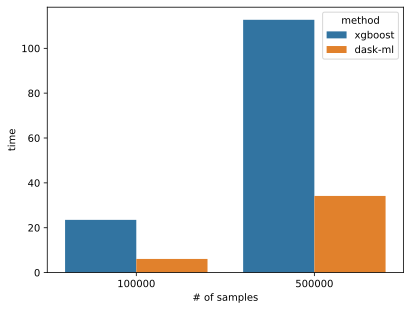

In [11]:
import xgboost as xgb

num_sample = [100_000, 500_000]
num_feature = 1_000
xgb_timings = []

for n in num_sample:
    X, y = dask_ml.datasets.make_classification(n_samples=n, 
        n_features=num_feature, 
        random_state=42,
        chunks=n // 10
    )
    dtrain = xgb.DMatrix(X, y)
    t1 = time.time()
    xgb.train(
        {"tree_method": "hist", "objective": "binary:hinge"},
        dtrain,
        num_boost_round=4,
        evals=[(dtrain, "train")],
        verbose_eval=False,
    )
    xgb_timings.append(('xgboost', n, time.time() - t1))
    dtrain_dask = xgb.dask.DaskDMatrix(client, X, y)
    t1 = time.time()
    xgb.dask.train(
        client,
        {"tree_method": "hist", "objective": "binary:hinge"},
        dtrain_dask,
        num_boost_round=4,
        evals=[(dtrain_dask, "train")],
        verbose_eval=False,
    )
    xgb_timings.append(('dask-ml', n, time.time() - t1))

df = pd.DataFrame(xgb_timings, columns=['method', '# of samples', 'time'])
sns.barplot(data=df, x='# of samples', y='time', hue='method')

If using XGBoost's scikit-learn-style API, you need to change [`xgboost.XGBClassifier`](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier) to [`xgboost.dask.DaskXGBClassifier`](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.dask.DaskXGBClassifier) or [`xgboost.XGBRegressor`](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor) to [`xgboost.dask.DaskXGBRegressor`](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.dask.DaskXGBRegressor).

### Distributed GPU Training

Dask can manage multiple GPUs, and XGBoost can perform multi-GPU training based on Dask. We need to install Dask-CUDA to launch a multi-GPU Dask cluster. Dask can distribute XGBoost training across several GPU devices.

In [4]:
from dask_cuda import LocalCUDACluster
import xgboost as xgb
client = Client(LocalCUDACluster())
client

/fs/fast/u20200002/envs/dispy/lib/python3.11/site-packages/distributed/deploy/spec.py:324: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44607 instead
  self.scheduler = cls(**self.scheduler_spec.get("options", {}))


<Client: 'tcp://127.0.0.1:33619' processes=4 threads=4, memory=90.00 GiB>

In [9]:
clf = xgb.dask.DaskXGBClassifier(verbosity=1)
clf.set_params(tree_method="hist", device="cuda")
clf.client = client

In [10]:
X, y = dask_ml.datasets.make_classification(n_samples=100_000, 
        n_features=1_000, 
        random_state=42,
        chunks=100_000 // 100
)
clf.fit(X, y, eval_set=[(X, y)], verbose=False)
prediction = clf.predict(X)

/fs/fast/u20200002/envs/dispy/lib/python3.11/site-packages/dask_ml/datasets.py:373: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  informative_idx, beta = dask.compute(
[23:01:19] task [xgboost.dask-0]:tcp://127.0.0.1:45305 got new rank 0
[23:01:19] task [xgboost.dask-1]:tcp://127.0.0.1:38835 got new rank 1
[23:01:19] task [xgboost.dask-2]:tcp://127.0.0.1:46315 got new rank 2
[23:01:20] task [xgboost.dask-3]:tcp://127.0.0.1:38331 got new rank 3
